# Pre-training VGG16 for Distillation

In [1]:
import torch 
import torch.nn as nn

from src.data.dataset import get_dataloader

import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SEED = 0

BATCH_SIZE = 32
LR = 5e-4
NUM_EPOCHES = 25

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_loader, val_loader, test_loader = get_dataloader("./data/CIFAR10/", BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [7]:
from src.models.model import VGG16_classifier

In [8]:
classes = 10
hidden_size = 512
dropout = 0.3

model = VGG16_classifier(classes, hidden_size, preprocess_flag=False, dropout=dropout).to(DEVICE)
model

VGG16_classifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [9]:
for img, label in train_loader:
    img = img.to(DEVICE)
    label = label.to(DEVICE)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([32, 3, 32, 32])
Label Dimensions: torch.Size([32])
----------------------------------------------------------------------------------------------------


C:\Users\udbha\anaconda3\envs\CPS803_Final_Project\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Output Dimensions: torch.Size([32, 10])


## Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [11]:
loss_hist = {"train accuracy": [], "train loss": [], "val accuracy": []}

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(train_loader):
        img = img.to(DEVICE)
        labels = labels.to(DEVICE)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()

    with torch.no_grad():
        model.eval()

        y_true_test = []
        y_pred_test = []

        for batch_idx, (img, labels) in enumerate(val_loader):
            img = img.to(DEVICE)
            label = label.to(DEVICE)

            preds = model(img)

            y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
            y_true_test.extend(labels.detach().tolist())

            test_total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
            test_total = len(y_pred_test)
            test_accuracy = test_total_correct * 100 / test_total
    
    loss_hist["train loss"].append(epoch_train_loss)

    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    loss_hist["val accuracy"].append(test_accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("       Validation Accuracy%: ", test_accuracy, "==", test_total_correct, "/", test_total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 2339.36016971
       Train Accuracy%:  39.394 == 19697 / 50000
       Validation Accuracy%:  58.94 == 2947 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 1438.08532357
       Train Accuracy%:  69.244 == 34622 / 50000
       Validation Accuracy%:  74.02 == 3701 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 1072.54530132
       Train Accuracy%:  78.84 == 39420 / 50000
       Validation Accuracy%:  72.7 == 3635 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 907.63304938
       Train Accuracy%:  82.384 == 41192 / 50000
       Validation Accuracy%:  79.96 == 3998 / 5000
-------------------------------------------------
-------------------------------------------

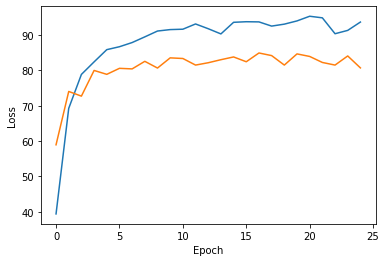

In [12]:
plt.plot(loss_hist["train accuracy"])
plt.plot(loss_hist["val accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

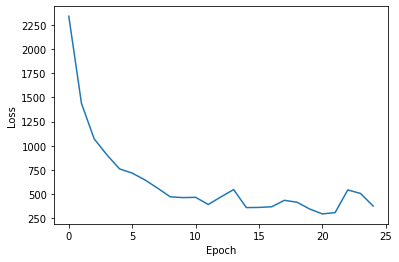

In [13]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Testing

In [14]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(test_loader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  81.04 == 4052 / 5000


## Saving Model Weights 

In [15]:
torch.save(model.state_dict(), "./trained_models/vgg16_cifar10.pt")